# Variational Autoencoder for Augmentation of Laser-Based Laryngeal Imaging

For the deep-learning-based algorithm to match features via a registration task, it is essential to apply intense data augmentation to the training data set. As displayed in the following figure the training data consists of images $m(x)$ that represent the spatial configuration of laser points projected onto the vocal fold surface.

![alt text here](images/feature_matching_registration.png "Logo Title Jupyter Notebook logo")

The foundation for the images $m(x)$ are the x-y-coordinates of each single laser point within the image, as $m(x)$ is generated by plotting the single laser points and then smoothing the image. To create intense augmentation we want to train a variational autoencoder (VAE) to then generate images that are variations of the images of the training set and represent feasible configurations of laser points projected onto a vocal fold. The implementation of the VAE is inspired by [Keras](https://keras.io/examples/generative/vae/).

In a VAE a decoder-encoder architecture is utilized. The coding is split up into a vector representing the mean $\mu$
of a distribution over a latent space. The distribution is assumed to be gaussian. Therefore, a second vector exists as a coding representing the variance $\mathbf{\sigma^2}$. Behind the coding a sampling layer exists that randomly samples a value from the distribution given by $\mathcal{N}(\mu,\,\sigma^{2})$. Like that it is possible to create a smooth latent space. The network can be trained in a unsupervised manner, as the the decoder should learn to reconstruct the input of the encoder as good as possible. After training, only the decoder part will be used. Inputing random points in the latent space will then generate x- and y-coordinates that are part of the underlying trained distribution based on the ground truth.

## Import Statements
The notebook was developed on Keras using the Tensorflow 2.2.0 backend.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter
from tensorflow.keras.callbacks import CSVLogger

## Hardware Configuration
Check for GPU and allow memory growth such that limitations for training are reduced. 

In [2]:
if len(tf.config.experimental.get_visible_devices('GPU')):
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Functionality
The following functionality helps to create the images for training the registration task.

In [3]:
def apply_smoothing(image, sigma=1.0, sigma_back=10.0):
    image_orig = image
    image = gaussian_filter(image, sigma=sigma)
    image_back = gaussian_filter(image, sigma=sigma_back)

    image = (image / image.max()) * 255
    image_back = (image_back / image_back.max()) * 255
    image = 0.3 * image_orig + 0.3 * image + 0.3 * image_back

    return image

In [4]:
def reconstruct_image(x_position, y_position):
    # Unpad
    x_position = x_position[1:-1, 1:-1]
    y_position = y_position[1:-1, 1:-1]
    image = np.zeros((image_height, image_width))
    for x, y in zip(x_position.flatten(), y_position.flatten()):
        x = int(x*image_width)
        y = int(y*image_height)
        
        if x >= 5 and y>= 5:
            image[y][x] = 1
        
    image = apply_smoothing(image, sigma=2, sigma_back=15)
    return image

## Model parameters
The grid dimensions have to be know, as well as the image dimensions for scaling. The depth of the input and output layer is 2 here, as we will have one channel representing x-coordinates and a second channel representing y-coordinates. 

In [5]:
grid_width = 18
grid_height = 18

image_width = 728
image_height = 728

inout_layers = 2

## Hyperparameters
The dimension of the latent space can be adapted to optimize the network. 

In [6]:
latent_dim = 8
epochs = 100
batch_size = 10
coding_loss_factor = 1.0
epsilon_factor = 1.0

## Sampling Layer
In the sampling layer the coding $\mathbf{\mu}$ and $\log{(\mathbf{\sigma^2})}$ are used to randomly sample a point from the underlying distribution. Due to this randomness that occurs within each batch and along all epochs the decoder is trained on smooth distributions. Each coding $\mathbf{c}$ used to train the decoder is computed as

$$\mathbf{c} = \mathbf{\mu} + e^{0.5\mathbf{\log{(\mathbf{\sigma^2})}}}\mathbf{\epsilon}f$$

where $\epsilon$ is a random vector with entries between 0 and 1 and $f$ is a hyperparameter to control the amount of randomness.

In [7]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon * epsilon_factor

## Encoder Model
In the encoder strided convolutional layers are applied to reduce the dimensionality of the input. For a grid with dimension 18x18 the input shape is increased to 20x20 and the input images are padded. Like that it is easier to ensure symmetry between encoder an decoder. The encoder is a keras model having the mean, variance and a sampled value as output.

In [8]:
encoder_inputs = keras.Input(shape=(grid_width+2, grid_height+2, inout_layers))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20, 20, 2)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 10, 10, 32)   608         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 5, 5, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 1600)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

## Decoder Model
The decoder takes only a sampeled value or a randomly selected value with the size of the latent space as input. 
The dimnesion of the input of the encoder is then reconstructed. The decoder is constructed as a keras model.

In [9]:
latent_inputs = keras.Input(shape=(latent_dim,))
y_val = (grid_height+2)//4
x_val = (grid_width+2)//4

x = layers.Dense(y_val*x_val*64, activation="relu")(latent_inputs)
x = layers.Reshape((y_val, x_val, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(inout_layers, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
#decoder.summary()

## VAE Model
The VAE is composed by the encoder and decoder. The decoder only takes the random coding $\mathbf{c}$ from the encoder. However, the codings $\mathbf{\mu}$ and $\log{(\mathbf{\sigma^2})}$ are used to compute a loss for regularizing and ensuring a smooth distribution. The coding loss is:

$$ \epsilon_{coding} = 1 + \log{(\sigma^2)} - \mu^2 - \sigma^2 $$

A binary crossentropy is used to define a reconstruction loss $\epsilon_{reconstruction}$. 
We are doing a regression here, based on probabilities. Therefore, cross entropy needs to be applied. See 
[Explanation](
https://stats.stackexchange.com/questions/223256/does-the-cross-entropy-cost-make-sense-in-the-context-of-regression). The overall loss is then:

$$\epsilon = \epsilon_{reconstruction} - \epsilon_{coding}$$

In [10]:
class VariationalAutoEncoder(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VariationalAutoEncoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
            
        # Gradient tape allows to "record" a function that will be derived
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            
            # Reconstuction Loss
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= grid_height+2 * grid_height+2
            
            # Regularization Loss for well formed latent space and no overfitting
            coding_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            coding_loss = tf.reduce_mean(coding_loss)
            coding_loss *= -(0.2 * coding_loss_factor)
            
            # Total Loss
            total_loss = reconstruction_loss + coding_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "coding_loss": coding_loss,
        }

## Prepare data
Load the data and scale them to be between 0.0 an 1.0. Further use zero-padding to get a 20x20 shape for this example. We use the already augmented data here for providing a large training set.

In [11]:
x_position = np.load('data/x_pos_LASTEN2A.npy')
y_position = np.load('data/y_pos_LASTEN2A.npy')

offset = 0.0

# Non existing points mapping
x_position = np.where(x_position<=0, -offset, x_position) + offset
y_position = np.where(x_position<=0, -offset, y_position) + offset

x_position = x_position / (image_width + offset)
y_position = y_position / (image_height + offset)

# Zero padding
x_position = np.pad(x_position,[(0,0),(1,1),(1,1)],constant_values=0)
y_position = np.pad(y_position,[(0,0),(1,1),(1,1)],constant_values=0)

x_position = x_position[:,:,:,np.newaxis]
y_position = y_position[:,:,:,np.newaxis]

xy_data = np.concatenate((x_position, y_position), axis=3)
print("Shape of 'xy_data': {}".format(xy_data.shape))

Shape of 'xy_data': (3200, 20, 20, 2)


## Training
Initialize the VAE, compile it and fit the model.

In [13]:
history = None

vae = VariationalAutoEncoder(encoder, decoder)

#vae.compile(optimizer=keras.optimizers.Adam())
#logger = CSVLogger("VAE_log")
#history = vae.fit(xy_data, callbacks=[logger], epochs=epochs, batch_size=batch_size)
#vae.save_weights('weights/vae/vae_100_epochs')

vae.load_weights('weights/vae/vae_100_epochs')

In [14]:
if history:
    print('Mean reconstruction loss over last 20 epochs: {}'.format(np.array(history.history['reconstruction_loss'][-20:]).mean()))
    print('Mean coding loss over last 20 epochs: {}'.format(np.array(history.history['coding_loss'][-20:]).mean()))
    plt.semilogy(history.history['reconstruction_loss'], label='Reconstruction Loss')
    plt.title('Crossentropy Loss for Reconstruction of Input images')
    plt.ylabel('Crossentropy')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.show()

## Predict images and compare with ground truth
Get the mean value for ground truth images and decode the value to reconstruct the images.

In [15]:
res_encoder = encoder.predict(xy_data)[0]
res_decoder = decoder.predict(res_encoder)
plt.rcParams["figure.figsize"] = (20,20)

### Predicition of x-coordinates by autoencoder
Out of all 8 recordings from the dataset one frame is displayed

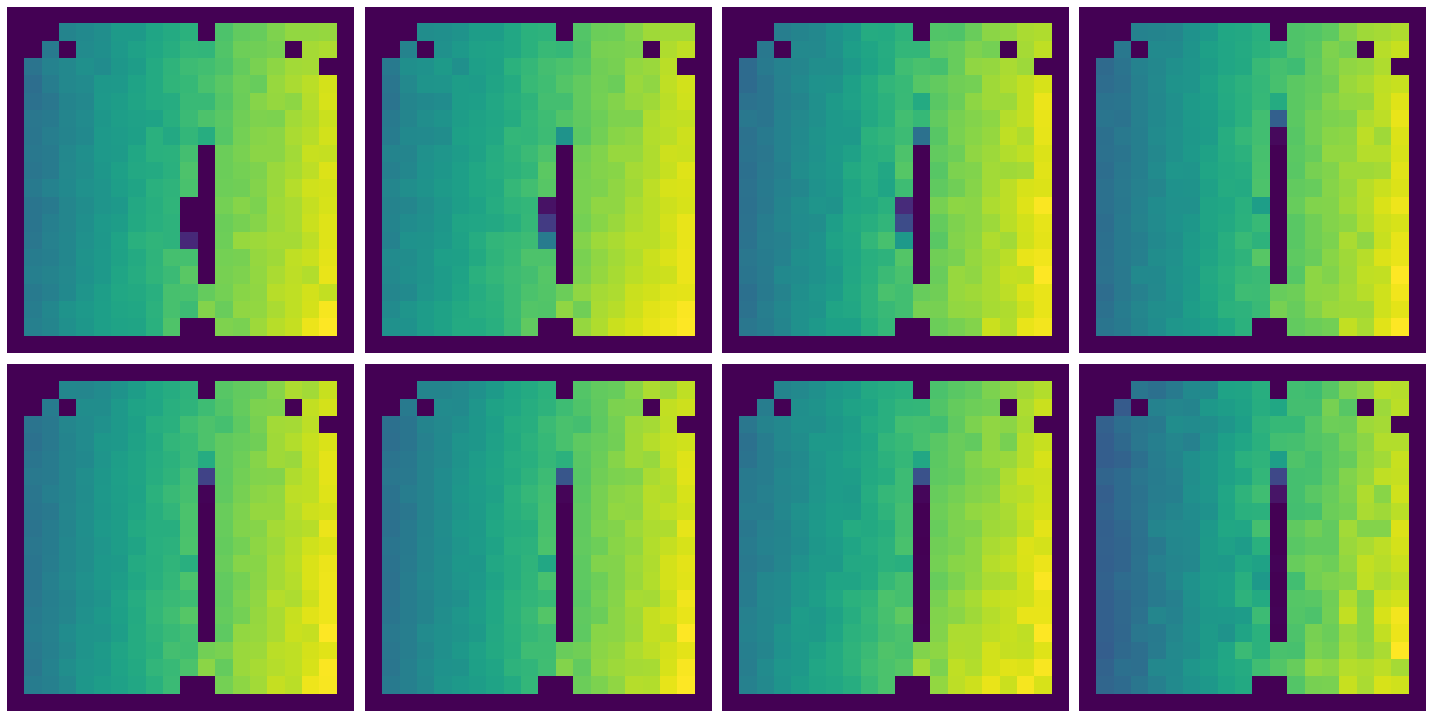

In [16]:
for i in range(8):
    val = 441 + i
    plt.subplot(val)
    x = res_decoder[i*20+200,:,:,0]
    plt.imshow(x)
    plt.axis('off')
    plt.tight_layout()

### Ground-truth of x-coordinates
Out of all 8 recordings from the dataset one frame is displayed.

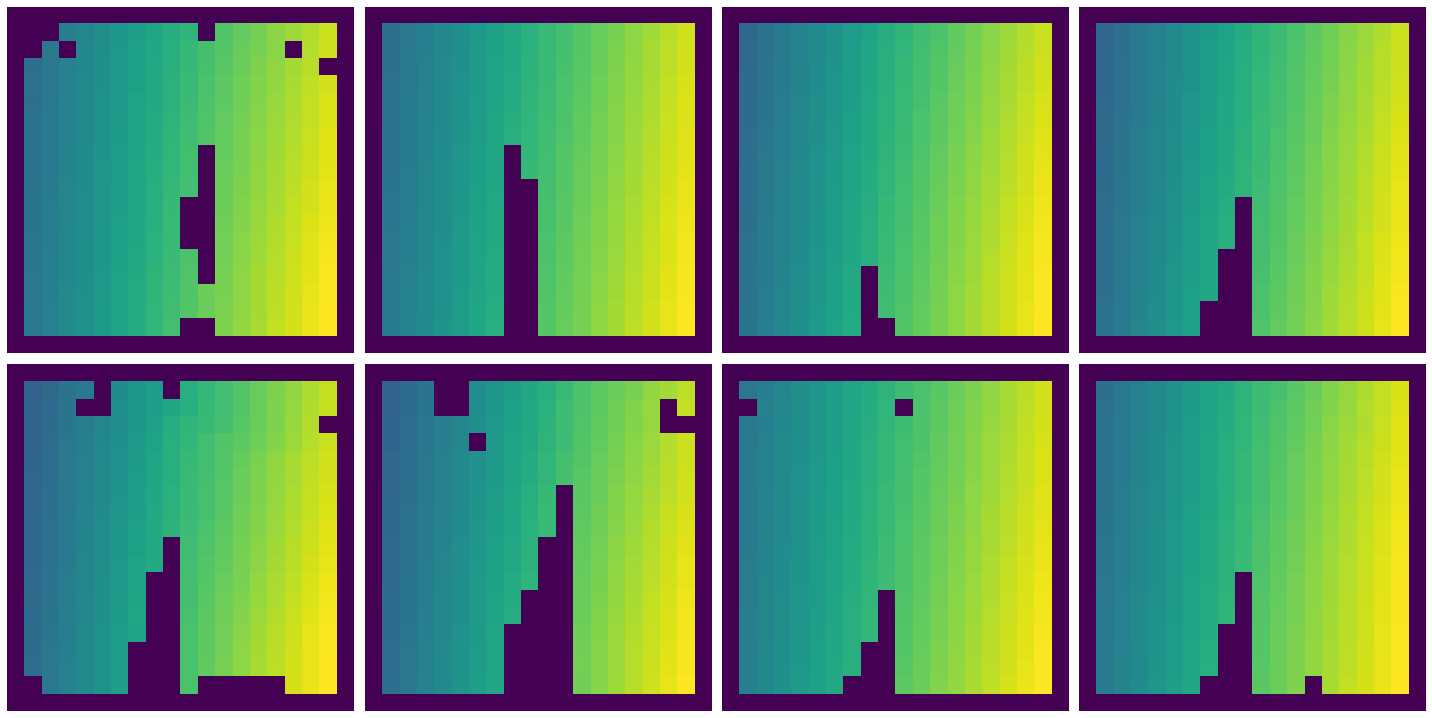

In [17]:
for i in range(8):
    val = 441 + i
    plt.subplot(val)
    x = xy_data[i*20,:,:,0]
    plt.imshow(x)
    plt.axis('off')
    plt.tight_layout()

### Predicition of x-y-coordinates and display in image space 
Out of all 8 recordings from the dataset one frame is displayed

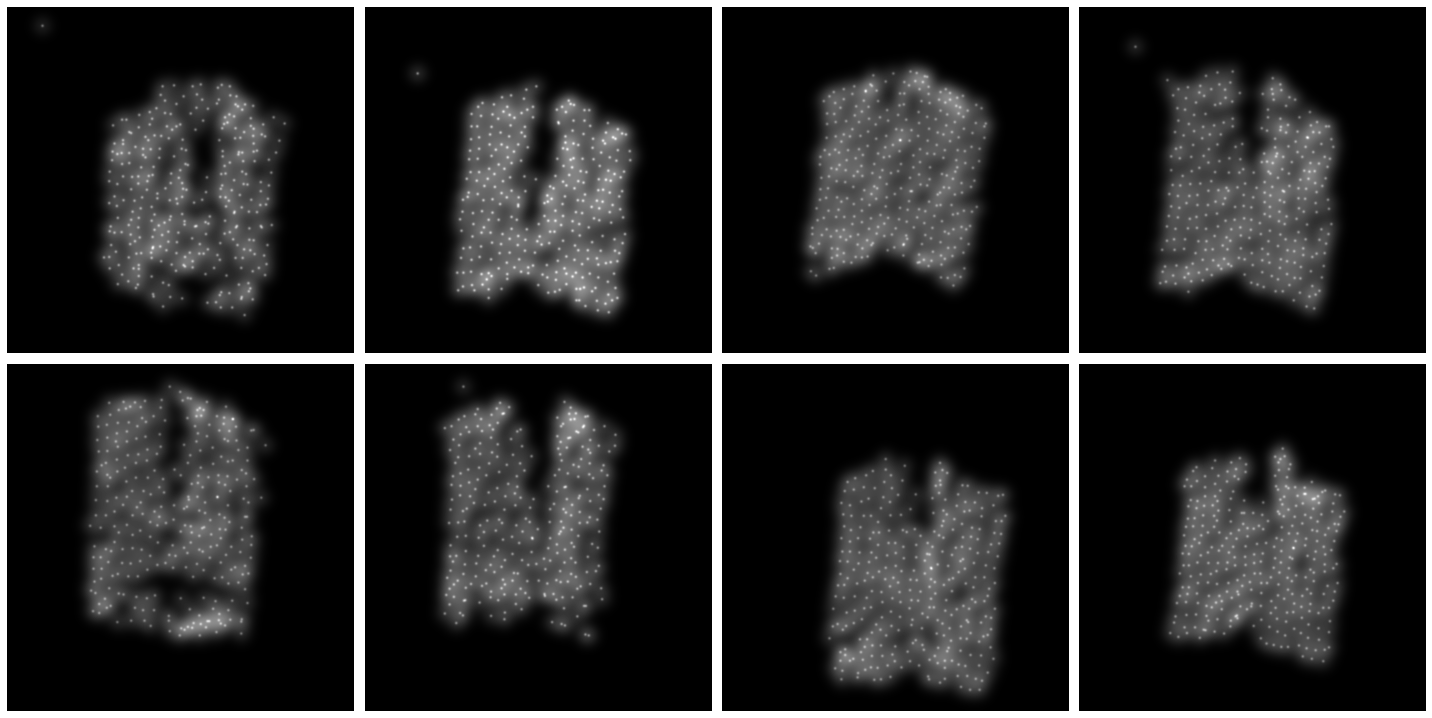

In [18]:
for i in range(8):
    val = 441 + i
    plt.subplot(val)
    x = res_decoder[i*20,:,:,0]
    y = res_decoder[i*20,:,:,1]
    plt.imshow(reconstruct_image(x, y),cmap='gist_gray')
    plt.axis('off')
    plt.tight_layout()

### Ground truth of x-y-coordinates and display in image space 
Out of all 8 recordings from the dataset one frame is displayed

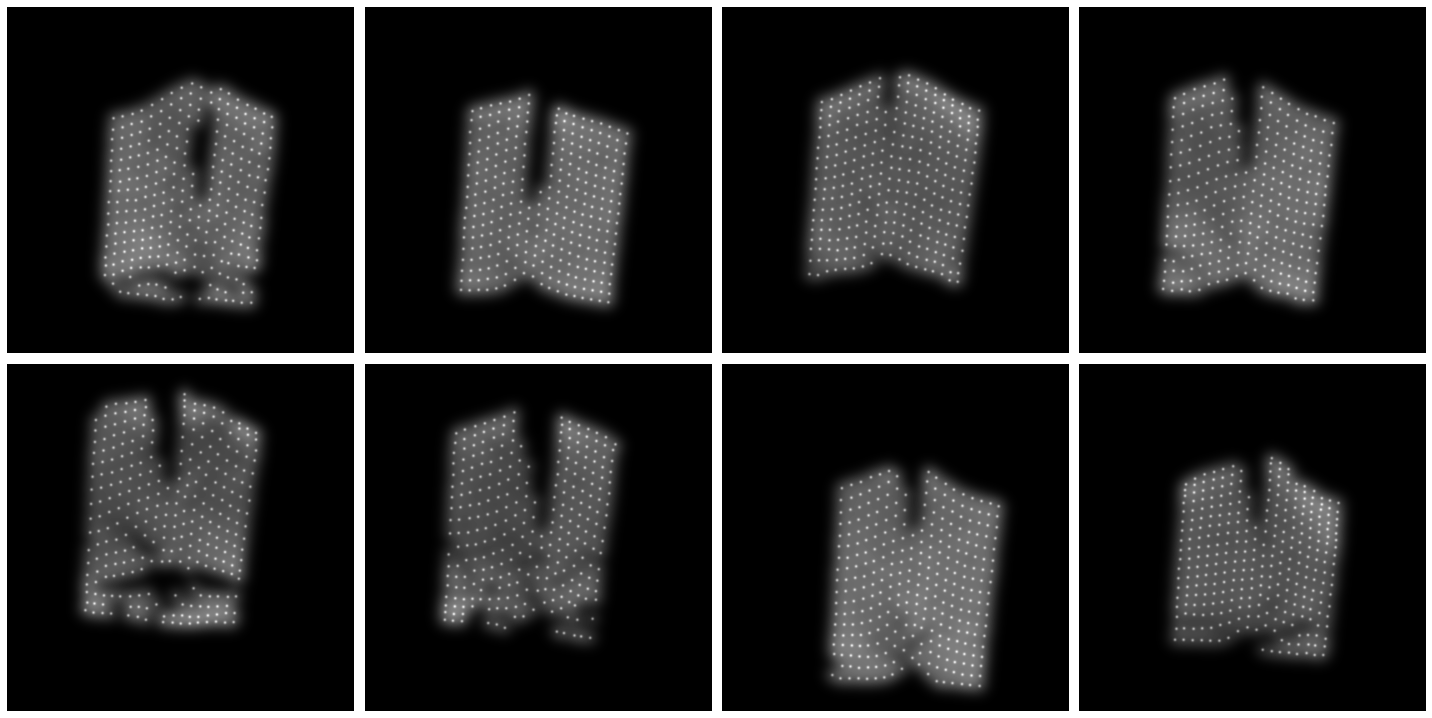

In [19]:
for i in range(8):
    val = 441 + i
    plt.subplot(val)
    x = xy_data[i*20,:,:,0]
    y = xy_data[i*20,:,:,1]
    plt.imshow(reconstruct_image(x, y),cmap='gist_gray')
    plt.axis('off')
    plt.tight_layout()

## Postprocessing
We apply a bilateral filter to denoise the coordinate images. Further irregularities in x- and y-direction are removed.

In [20]:
from skimage.restoration import denoise_bilateral
plt.rcParams["figure.figsize"] = (7,7)

def postprocess_coordinate_images(results, index):
    x = results[index,:,:,0]
    y = results[index,:,:,1]
    
    # Unpad
    x = x[1:-1,1:-1]
    y = y[1:-1,1:-1]
    
    x_max_orig = x.max()
    y_max_orig = y.max()
    
    # Smooth
    x = denoise_bilateral(x, mode='edge',sigma_spatial=100, win_size=3)
    y = denoise_bilateral(y, mode='edge',sigma_spatial=100, win_size=3)
    
    # Equalize possible offset due to smoothing
    x = x - x.min()
    y = y - y.min()
    
    x = x * (x_max_orig / x.max())
    y = y * (y_max_orig / y.max())
    
    # Sort out irregularities in x
    for i in range(len(x)):        
        max_value=0.0
        for j in range(len(x[i])):
            if x[i][j] <= max_value:
                x[i][j] = 0.0
                y[i][j] = 0.0
            else: 
                max_value = x[i][j]
            
    # Sort out irregularities in y
    for i in range(len(y[0])):        
        max_value=0.0
        for j in reversed(range(len(y))):
            if y[j][i] <= max_value:
                x[j][i] = 0.0
                y[j][i] = 0.0
            else:
                max_value = y[j][i]
    
    return x, y        

## Predict codings based on the training data

In [21]:
res_encoder = encoder.predict(xy_data)

## Generate an image based on a vector from the latent space
Use this functionality to explore the latent space.

In [22]:
%%capture
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, widgets
from IPython.display import display

def f(**sliders):
    image_id = 0
    
    sliders_float = [float(slider[1]) for slider in sliders.items()]
    
    res_encoder_offset = np.array([sliders_float])
    res_decoder = decoder.predict(res_encoder[0][image_id] + res_encoder_offset)
    
    x, y = postprocess_coordinate_images(res_decoder, image_id)

    img = reconstruct_image(x, y)
    ax.imshow(img, cmap="gray")
    display(fig)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_axes(plt.axes())
fig.canvas.draw()
ax.axis('off')


sliders = {str(i): widgets.FloatSlider(min=-2.0,max=2.0,step=0.5,value=0.0, continuous_update=False) for i in range(latent_dim)}


In [23]:
_ = interact(f, **sliders)

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='0', max=2.0, min=-2.0, step…

## Draw samples from the distribution
First we want to have a look, how the data is distributed. We highlight the first frame of all recordings as they mainly define the data set.

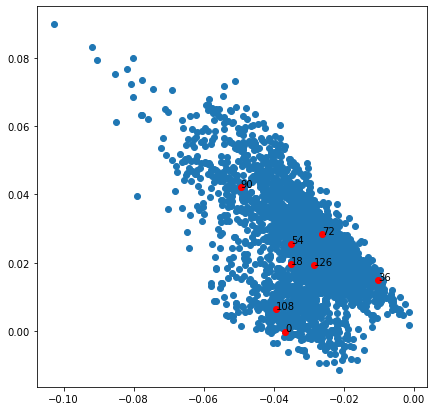

In [43]:
plt.rcParams["figure.figsize"] = (7,7)

dim1 = res_encoder[0][:,0]
dim2 = res_encoder[0][:,1]
dim3 = res_encoder[0][:,2]
dim4 = res_encoder[0][:,3]
dim5 = res_encoder[0][:,4]
dim6 = res_encoder[0][:,5]
dim7 = res_encoder[0][:,6]
dim8 = res_encoder[0][:,7]

dim = dim2

plt.scatter(dim1, dim)
for i in range(8):
    image_id = i*18
    plt.scatter(dim1[image_id], dim[image_id],c='r')
    plt.text(dim1[image_id], dim[image_id], str(image_id))

There are several possibilties to draw samples from the latent space.
1. Predict the latent vector of one sample image and pertubate it.
2. Linearly Interpolate between neighbors.
3. Linearly Extrapolate with neighbors. (Not discussed here)

### 1. Predict the latent vector of one sample image and pertubate it.
Pertubation is computed as a value from a normal distribution with zero mean. A coding $\hat{\mathbf{c}}$ can be sampled as:
$$\hat{\mathbf{c}} = \mathbf{\mu} + e^{0.5\mathbf{\log{(\mathbf{\sigma^2})}}}\mathbf{\epsilon}f$$

where $\mathbf{\epsilon}$ is a random value from a normal distribution and $f$ allows us to control the amount of pertubation.

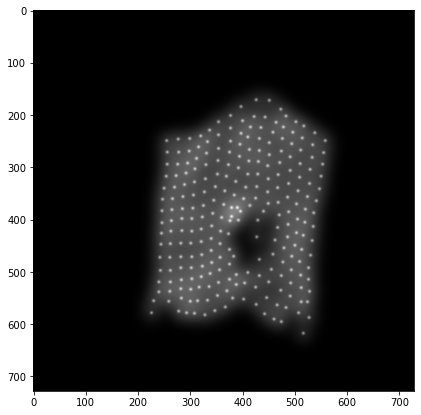

In [90]:
plt.rcParams["figure.figsize"] = (7,7)

image_id = 18

epsilon = np.random.normal(size=res_encoder[0].shape)
variation = res_encoder[0]#+np.exp(0.5 * res_encoder[1]) * epsilon * 3

res_decoder = decoder.predict(variation)
new_x, new_y = postprocess_coordinate_images(res_decoder, image_id)
plt.imshow(reconstruct_image(new_x, new_y),cmap='gist_gray')

### 2. Linearly Interpolate between neighbors
First we define a function to linearly interpolate a coding between two existing codings with a factor $\alpha$ in $[0,1]$. Therefore, we define:
$$ \hat{\mathbf{c}} = (\mathbf{\mu}_2 - \mathbf{\mu}_1)\alpha + \mathbf{\mu}_1$$

In [32]:
def interpolate_codings(first_coding, second_coding, alpha):
    return (second_coding - first_coding) * alpha + first_coding

Here we select four ground truth images for which we first compute the coding through the encoder. Then we sample with a factor of $\alpha$, values between the first and the second image and the third and the fourth image. After, we sample again between the previously sampled points to cover approximatley the space between all ground truth images. 

In [94]:
first_image_id = 0
second_image_id = 108
third_image_id = 54
fourth_image_id = 18

first_coding = res_encoder[0][first_image_id]
second_coding = res_encoder[0][second_image_id]
third_coding = res_encoder[0][third_image_id]
fourth_coding = res_encoder[0][fourth_image_id]

alphas = list(np.arange(0.0,1.1,0.2))
size = len(alphas)

first_2_second_codings = np.array([interpolate_codings(first_coding, second_coding, alpha) for alpha in alphas])
third_2_fourth_codings = np.array([interpolate_codings(third_coding, fourth_coding, alpha) for alpha in alphas])

codings = np.zeros((size, size, latent_dim))

for i in range(size):
    first_2_second_coding = first_2_second_codings[i]
    third_2_fourth_coding = third_2_fourth_codings[i]
    
    vertical_codings = np.array([interpolate_codings(first_2_second_coding, third_2_fourth_coding, alpha) for alpha in alphas])
    
    codings[:, i, :] = vertical_codings

codings = codings.reshape((size * size, latent_dim))
res_decoder = decoder.predict(codings)

x_coords = list()
y_coords = list()

for i in range(size * size):
    x, y = postprocess_coordinate_images(res_decoder, i)
    x_coords.append(x)
    y_coords.append(y)

We can now display the learned manifold:

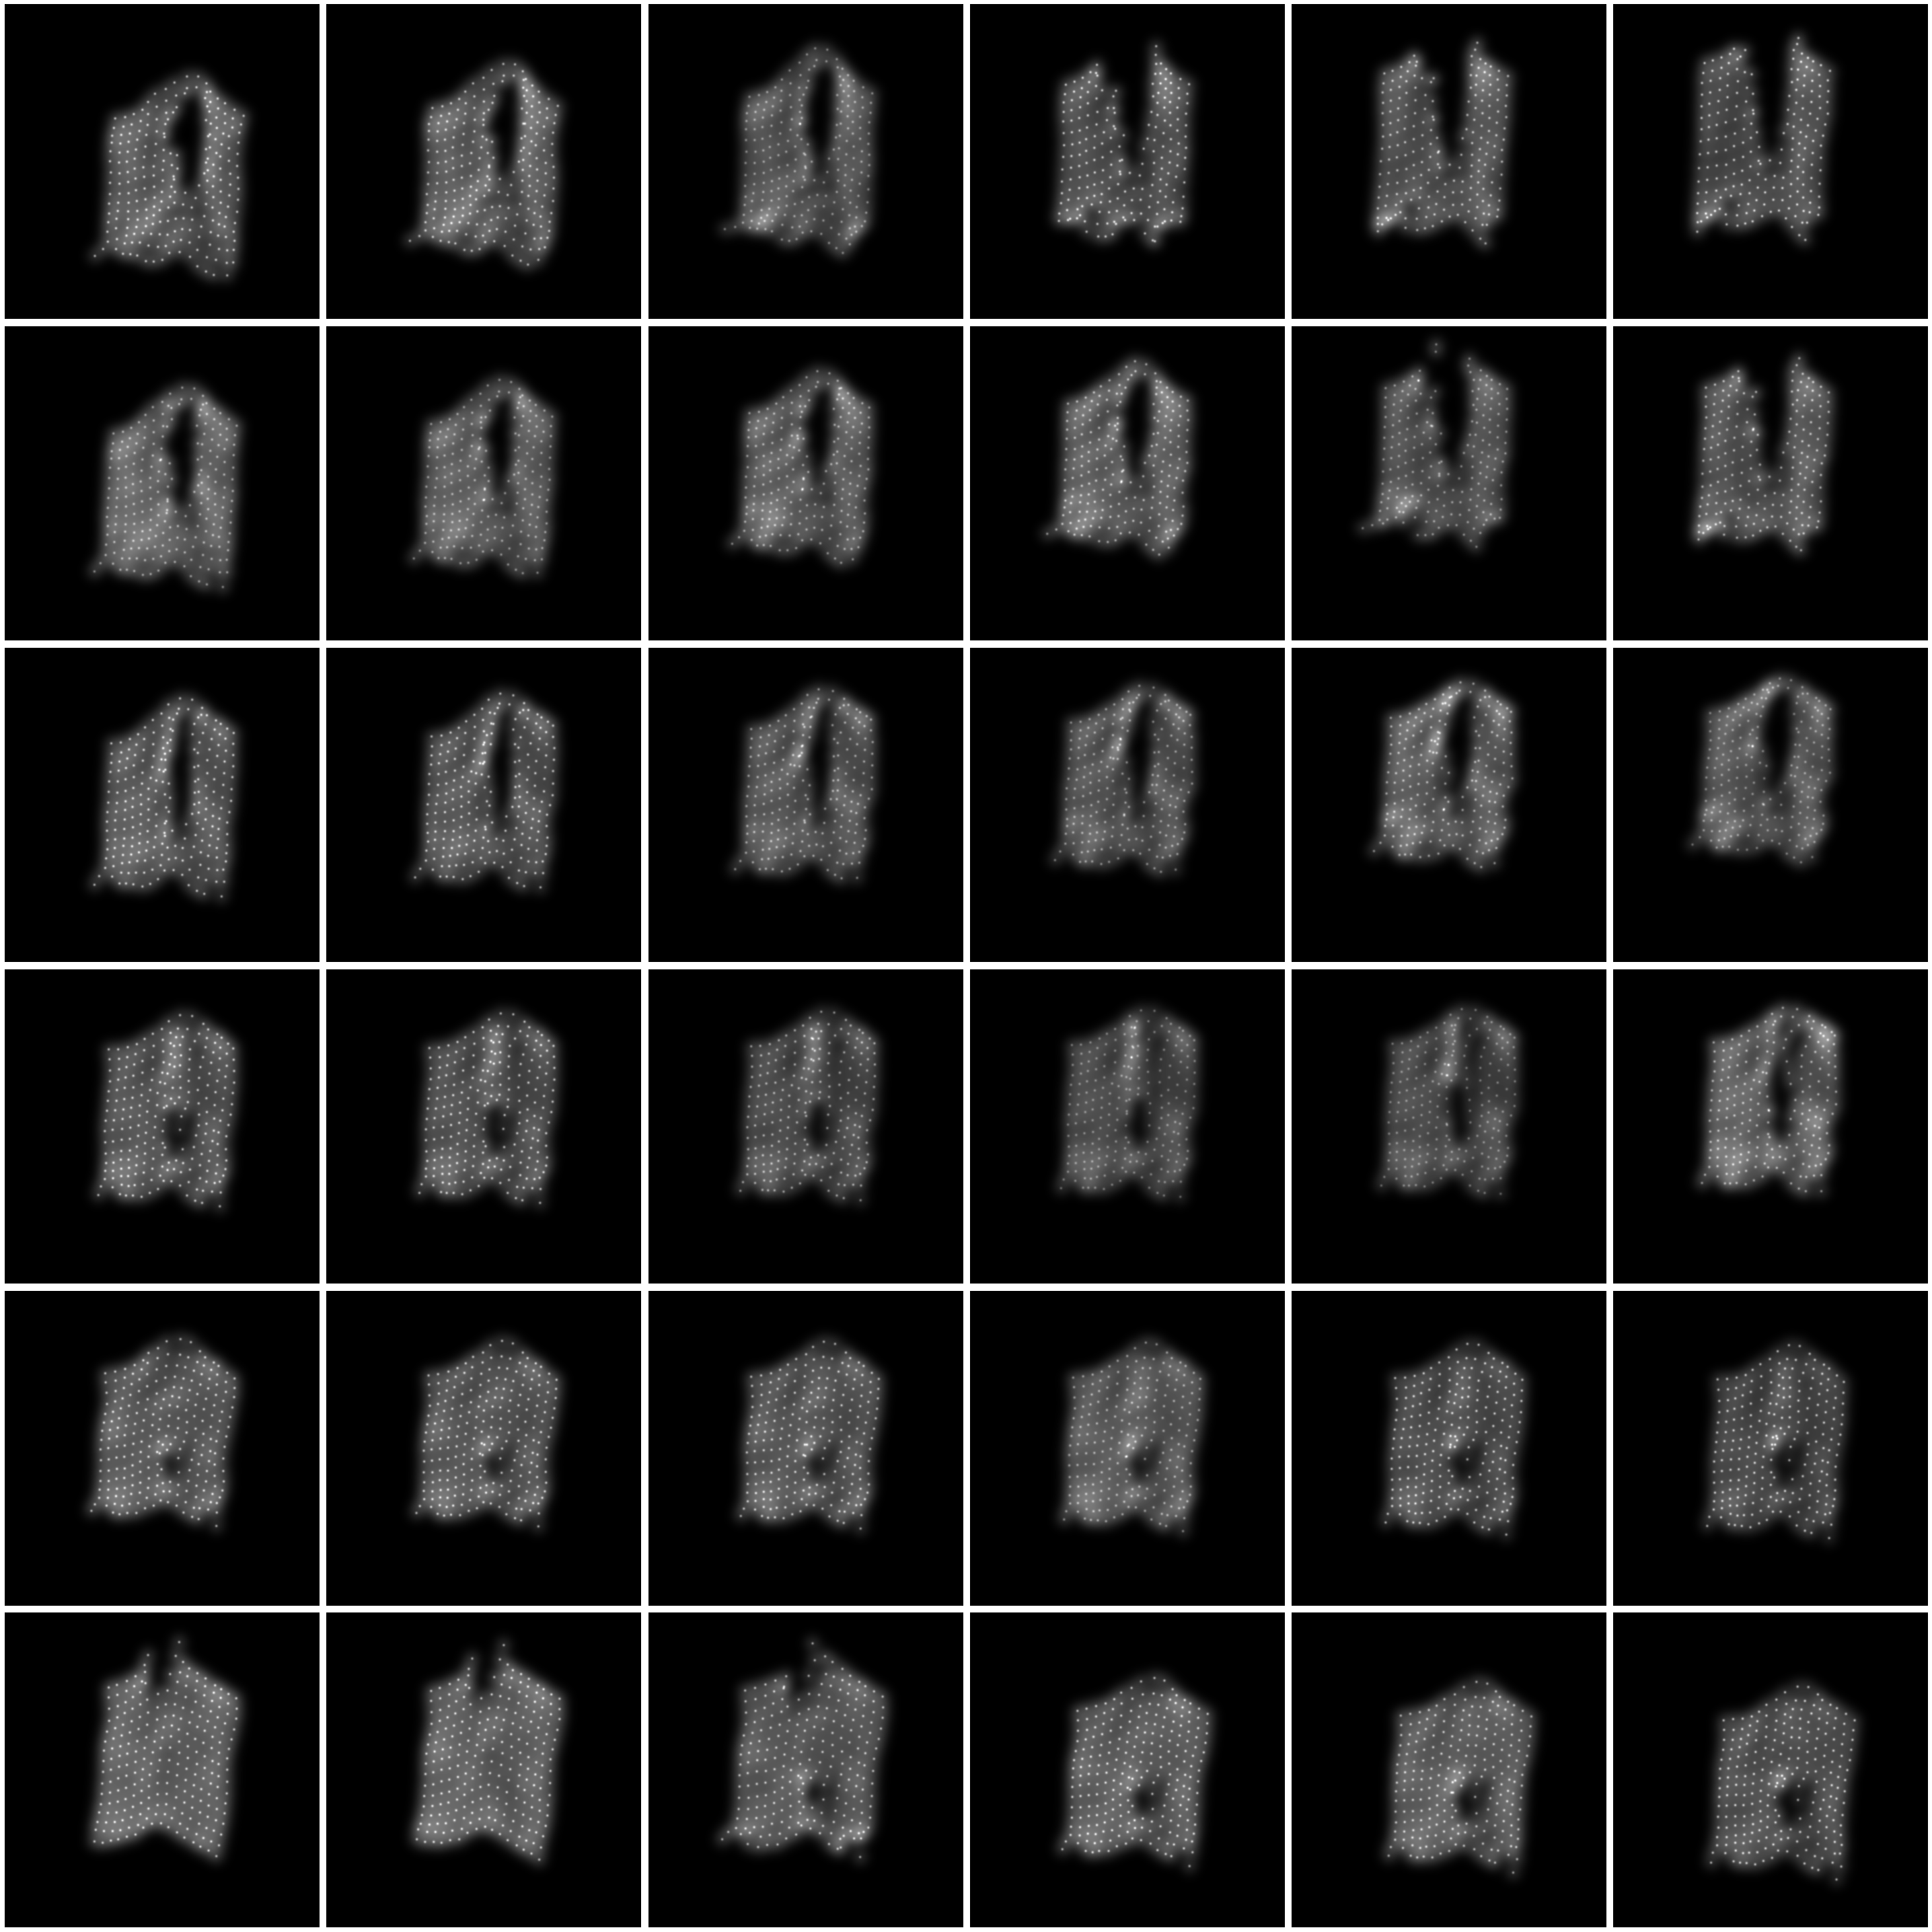

In [97]:
plt.rcParams["figure.figsize"] = (40,40)

for i in range(size * size):
    x = x_coords[i]
    y = y_coords[i]
    
    plt.subplot(size, size, i+1)
    plt.imshow(reconstruct_image(x, y),cmap='gist_gray')
    plt.axis('off')
    plt.tight_layout()
    
plt.savefig('learned_manifold.png')